In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the triplet dataset
triplet_data = pd.read_csv('triplet_dataset1.csv')


label_distribution = triplet_data['label'].value_counts()

# Print the distribution of labels
print("Distribution of labels:")
print(label_distribution)


Distribution of labels:
label
father-son      1593
mother-son      1543
father-dau      1536
mother-dau      1531
none            1510
similar face    1492
Name: count, dtype: int64


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the triplet dataset
triplet_data = pd.read_csv('triplet_dataset1.csv')

# Split the dataset into training and validation sets (80:20 ratio)
train_data, val_data = train_test_split(triplet_data, test_size=0.2, random_state=42)

# Save the split datasets to CSV files
train_data.to_csv('train_triplet_dataset1.csv', index=False)
val_data.to_csv('val_triplet_dataset1.csv', index=False)

print(f"Training dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")

Training dataset size: 7364
Validation dataset size: 1841


In [1]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms

class TripletKinshipDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.label_mapping = {
            'father-dau': 0,
            'father-son': 1,
            'mother-dau': 2,
            'mother-son': 3,
            'similar face': 4,
            'none': 5
        }
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor_path = self.data.iloc[idx, 0]
        positive_path = self.data.iloc[idx, 1]
        negative_path = self.data.iloc[idx, 2]
        relationship_label = self.data.iloc[idx, 3]

        # Convert relationship label to its mapped numerical value
        label = self.label_mapping[relationship_label]

        anchor_img = self.transform(Image.open(anchor_path).convert('RGB'))
        positive_img = self.transform(Image.open(positive_path).convert('RGB'))
        negative_img = self.transform(Image.open(negative_path).convert('RGB'))

        return anchor_img, positive_img, negative_img, torch.tensor(label, dtype=torch.long)




In [2]:
import pandas as pd
# Load a small sample of the dataset for debugging
csv_file_path = 'triplet_dataset1.csv'
pd.read_csv(csv_file_path)
dataset = TripletKinshipDataset(csv_file=csv_file_path)
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Flatten the output

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self, num_classes=6):  # Assuming 6 classes for kinship relationships
        super(SiameseNetwork, self).__init__()
        self.embedding_model = ResNetFeatureExtractor()
        self.fc = nn.Sequential(
            nn.Linear(2048 * 2 + 1, 512),  # Concatenated features + distance
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward_once(self, img):
        return self.embedding_model(img)

    def forward(self, anchor_img, positive_img, negative_img):
        anchor_output = self.forward_once(anchor_img)
        positive_output = self.forward_once(positive_img)
        negative_output = self.forward_once(negative_img)
        return anchor_output, positive_output, negative_output

    def classify(self, img1, img2):
        output1 = self.forward_once(img1)
        output2 = self.forward_once(img2)
        distance = F.pairwise_distance(output1, output2, keepdim=True)
        combined_features = torch.cat((output1, output2, distance), dim=1)
        relationship_output = self.fc(combined_features)
        return relationship_output


In [5]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = F.pairwise_distance(anchor, positive, keepdim=True)
        negative_distance = F.pairwise_distance(anchor, negative, keepdim=True)
        loss = torch.mean(torch.clamp(positive_distance - negative_distance + self.margin, min=0.0))
        return loss

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader

In [8]:
# Initialize the network, loss function, and optimizer
siamese_net = SiameseNetwork(num_classes=6)
triplet_criterion = TripletLoss(margin=1.0)
relationship_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=0.0001)

c:\Users\gaura\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gaura\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Load the datasets
train_dataset = TripletKinshipDataset(csv_file='train_triplet_dataset1.csv')
val_dataset = TripletKinshipDataset(csv_file='val_triplet_dataset1.csv')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [9]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
siamese_net.to(device)

SiameseNetwork(
  (embedding_model): ResNetFeatureExtractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu)

In [8]:
import torch

# Clear cache
torch.cuda.empty_cache()

In [12]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    siamese_net.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i, data in enumerate(train_loader, 0):
        anchor_img, positive_img, negative_img, label = data
        anchor_img, positive_img, negative_img, label = anchor_img.to(device), positive_img.to(device), negative_img.to(device), label.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        anchor_output, positive_output, negative_output = siamese_net(anchor_img, positive_img, negative_img)
        triplet_loss = triplet_criterion(anchor_output, positive_output, negative_output)

        relationship_output = siamese_net.classify(anchor_img, positive_img)
        relationship_loss = relationship_criterion(relationship_output, label)

        loss = triplet_loss + relationship_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
                # Calculate accuracy
        _, predicted = torch.max(relationship_output.data, 1)
        correct_predictions += (predicted == label).sum().item()
        total_samples += label.size(0)
        if i % 10 == 9:  # Print every 10 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0
    # Calculate and print training accuracy for the epoch
    accuracy = 100 * correct_predictions / total_samples
    print(f'Epoch [{epoch + 1}/{num_epochs}] Training Accuracy: {accuracy:.2f}%')

    # Validation
    siamese_net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            anchor_img, positive_img, negative_img, label = data
            anchor_img, positive_img, negative_img, label = anchor_img.to(device), positive_img.to(device), negative_img.to(device), label.to(device)

            anchor_output, positive_output, negative_output = siamese_net(anchor_img, positive_img, negative_img)
            triplet_loss = triplet_criterion(anchor_output, positive_output, negative_output)

            relationship_output = siamese_net.classify(anchor_img, positive_img)
            relationship_loss = relationship_criterion(relationship_output, label)

            loss = triplet_loss + relationship_loss
            val_loss += loss.item()

            _, predicted = torch.max(relationship_output, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

Epoch [1/10], Batch [10], Loss: 2.0567
Epoch [1/10], Batch [20], Loss: 1.8536
Epoch [1/10], Batch [30], Loss: 1.6433
Epoch [1/10], Batch [40], Loss: 1.4705
Epoch [1/10], Batch [50], Loss: 1.4480
Epoch [1/10], Batch [60], Loss: 1.4457
Epoch [1/10], Batch [70], Loss: 1.4312
Epoch [1/10], Batch [80], Loss: 1.3341
Epoch [1/10], Batch [90], Loss: 1.3620
Epoch [1/10], Batch [100], Loss: 1.3597
Epoch [1/10], Batch [110], Loss: 1.3764
Epoch [1/10], Batch [120], Loss: 1.2494
Epoch [1/10], Batch [130], Loss: 1.3296
Epoch [1/10], Batch [140], Loss: 1.2183
Epoch [1/10], Batch [150], Loss: 1.2529
Epoch [1/10], Batch [160], Loss: 1.1584
Epoch [1/10], Batch [170], Loss: 1.1279
Epoch [1/10], Batch [180], Loss: 1.1253
Epoch [1/10], Batch [190], Loss: 1.1861
Epoch [1/10], Batch [200], Loss: 1.2011
Epoch [1/10], Batch [210], Loss: 1.1612
Epoch [1/10], Batch [220], Loss: 1.0994
Epoch [1/10], Batch [230], Loss: 1.1309
Epoch [1/10], Batch [240], Loss: 1.1539
Epoch [1/10], Batch [250], Loss: 1.2697
Epoch [1/

In [13]:
torch.save(siamese_net.state_dict(), 'siamese_net1.pth')
print("Model saved to siamese_net.pth")

Model saved to siamese_net.pth


In [20]:
# Assuming your batch losses are stored in a list:
batch_losses = [
    2.0567, 1.8536, 1.6433, 1.4705, 1.4480, 1.4457, 1.4312, 1.3341, 1.3620, 1.3597, # Epoch 1
    1.3764, 1.2494, 1.3296, 1.2183, 1.2529, 1.1584, 1.1279, 1.1253, 1.1861, 1.2011, # Epoch 1
    1.1612, 1.0994, 1.1309, 1.1539, 1.2697, 1.0656, 1.0478, 1.1607, 1.2882, 1.0949, # Epoch 1
    1.2212, 1.1852, 0.9213, 1.0631, 1.0733, 1.0049, 0.9245, 0.9195, 1.1499, 1.1004, # Epoch 1
    1.1355, 1.2343, 1.0890, 1.0183, 1.0139, 0.8961, # End of Epoch 1
    
    0.8608, 0.7974, 0.9487, 1.0641, 0.8701, 0.8540, 0.9097, 0.9273, 0.7380, 0.8817, # Epoch 2
    0.8281, 0.7341, 0.9210, 0.9320, 0.6495, 0.8768, 0.8146, 0.8156, 0.8739, 0.7207, # Epoch 2
    0.8386, 0.7061, 0.9407, 0.7018, 0.6741, 0.8952, 0.8272, 0.6930, 0.7049, 0.8092, # Epoch 2
    0.8555, 0.6983, 0.7730, 0.7092, 0.7739, 0.9571, 0.8710, 0.8385, 0.7215, 0.7572, # Epoch 2
    0.7537, 0.8459, 0.7241, 0.6795, 0.7329, 0.7649, # End of Epoch 2
    
    0.5427, 0.6005, 0.5747, 0.8552, 0.7396, 0.6358, 0.5904, 0.6544, 0.5937, 0.7616, 
    0.6143, 0.5796, 0.7146, 0.8373, 0.7090, 0.5953, 0.6134, 0.6322, 0.7261, 0.8254, 
    0.6343, 0.6015, 0.6650, 0.7002, 0.6611, 0.6183, 0.6030, 0.5638, 0.6896, 0.5597, 
    0.5872, 0.7599, 0.6223, 0.6174, 0.5337, 0.5404, 0.6825, 0.5279, 0.6194, 0.5383, 
    0.6374, 0.4789, 0.5590, 0.8593, 0.6509, 0.6140,
    
    0.6536, 0.6534, 0.5405, 0.5323, 0.6447, 0.4458, 0.5344, 0.4616, 0.4339, 0.4058,
    0.5233, 0.5394, 0.5065, 0.4683, 0.4568, 0.5117, 0.4398, 0.5945, 0.6006, 0.6818,
    0.5313, 0.5162, 0.5448, 0.5434, 0.4996, 0.5707, 0.4314, 0.4975, 0.4991, 0.6574,
    0.5039, 0.5407, 0.6233, 0.5300, 0.5672, 0.5505, 0.4606, 0.4241, 0.6505, 0.4497,
    0.4056, 0.5192, 0.5372, 0.5531, 0.5159, 0.5015,
    
    0.4199, 0.5335, 0.5049, 0.3632, 0.4061, 0.4626, 0.3935, 0.4304, 0.4202, 0.4146,
    0.3436, 0.4239, 0.4040, 0.4885, 0.4459, 0.4066, 0.4757, 0.4415, 0.4745, 0.3470,
    0.4183, 0.3886, 0.3762, 0.5613, 0.3121, 0.4769, 0.4784, 0.3608, 0.3970, 0.4052,
    0.3867, 0.4144, 0.4586, 0.3166, 0.4035, 0.2831, 0.3072, 0.4737, 0.4852, 0.3459,
    0.3716, 0.3882, 0.5181, 0.5474, 0.5219, 0.5013,
    
    0.4089, 0.4395, 0.4430, 0.3959, 0.2885, 0.3286, 0.3393, 0.4283, 0.3922, 0.3104,
    0.4585, 0.3476, 0.2840, 0.2991, 0.3616, 0.3750, 0.2931, 0.3624, 0.3285, 0.2813,
    0.3978, 0.4165, 0.3463, 0.3394, 0.4688, 0.3546, 0.3814, 0.4212, 0.3738, 0.3577,
    0.4465, 0.2941, 0.4347, 0.3282, 0.4125, 0.3582, 0.3740, 0.3560, 0.3611, 0.4454,
    0.4011, 0.3337, 0.3312, 0.4050, 0.3630, 0.4587,
    
    0.2994, 0.2694, 0.2303, 0.3328, 0.3287, 0.3176, 0.2863, 0.2856, 0.2787, 0.3440,
    0.3001, 0.3083, 0.2423, 0.2916, 0.3591, 0.2403, 0.3836, 0.2976, 0.2568, 0.2843,
    0.2101, 0.2589, 0.2949, 0.3500, 0.2659, 0.2013, 0.2781, 0.2735, 0.3666, 0.3128,
    0.3839, 0.3169, 0.2233, 0.2992, 0.2945, 0.2947, 0.3383, 0.2822, 0.2348, 0.3904,
    0.4085, 0.3058, 0.4405, 0.3574, 0.3196, 0.3677,
    
    0.2632, 0.2537, 0.3072, 0.2779, 0.2264, 0.3024, 0.2209, 0.2065, 0.2045, 0.3233,
    0.2035, 0.2215, 0.3605, 0.2379, 0.3163, 0.3420, 0.2465, 0.3546, 0.3643, 0.2609,
    0.2815, 0.1952, 0.2681, 0.2539, 0.3099, 0.2597, 0.2767, 0.4188, 0.2721, 0.1766,
    0.2281, 0.1987, 0.3415, 0.2391, 0.1960, 0.2967, 0.2028, 0.3139, 0.1943, 0.2368,
    0.3178, 0.3554, 0.2002, 0.2338, 0.2261, 0.2470,
    
    0.1967, 0.2192, 0.1762, 0.1980, 0.1260, 0.2122, 0.2324, 0.1931, 0.2389, 0.1737,
    0.2121, 0.2370, 0.2610, 0.2180, 0.2205, 0.2244, 0.1665, 0.1678, 0.2365, 0.2476,
    0.2420, 0.2519, 0.3421, 0.3884, 0.2337, 0.1720, 0.1956, 0.2436, 0.1972, 0.2462,
    0.2082, 0.2440, 0.2622, 0.2563, 0.1920, 0.2747, 0.1673, 0.2335, 0.1579, 0.3000,
    0.2388, 0.2344, 0.3101, 0.3017, 0.2646, 0.1663,
    
    0.1824, 0.2566, 0.1701, 0.2162, 0.1620, 0.1458, 0.2298, 0.2812, 0.1727, 0.2028,
    0.2305, 0.1413, 0.2570, 0.2439, 0.2884, 0.1755, 0.2615, 0.2371, 0.1330, 0.2272,
    0.1615, 0.1858, 0.2035, 0.2096, 0.2897, 0.1918, 0.2058, 0.2035, 0.1832, 0.1968,
    0.2011, 0.2521, 0.3207, 0.1855, 0.1521, 0.1695, 0.2163, 0.2105, 0.2333, 0.2595,
    0.1670, 0.3156, 0.1923, 0.2341, 0.2316, 0.1828
    
    
]

# Assuming 460 batches per epoch (as in your provided logs)
num_batches_per_epoch = 46
num_epochs = 10

In [21]:
average_epoch_losses = []

for epoch in range(num_epochs):
    start_idx = epoch * num_batches_per_epoch
    end_idx = (epoch + 1) * num_batches_per_epoch
    epoch_loss = sum(batch_losses[start_idx:end_idx]) / num_batches_per_epoch
    average_epoch_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Training Loss: {epoch_loss:.4f}')

Epoch [1/10], Average Training Loss: 1.2185
Epoch [2/10], Average Training Loss: 0.8101
Epoch [3/10], Average Training Loss: 0.6418
Epoch [4/10], Average Training Loss: 0.5272
Epoch [5/10], Average Training Loss: 0.4239
Epoch [6/10], Average Training Loss: 0.3723
Epoch [7/10], Average Training Loss: 0.3045
Epoch [8/10], Average Training Loss: 0.2660
Epoch [9/10], Average Training Loss: 0.2279
Epoch [10/10], Average Training Loss: 0.2124


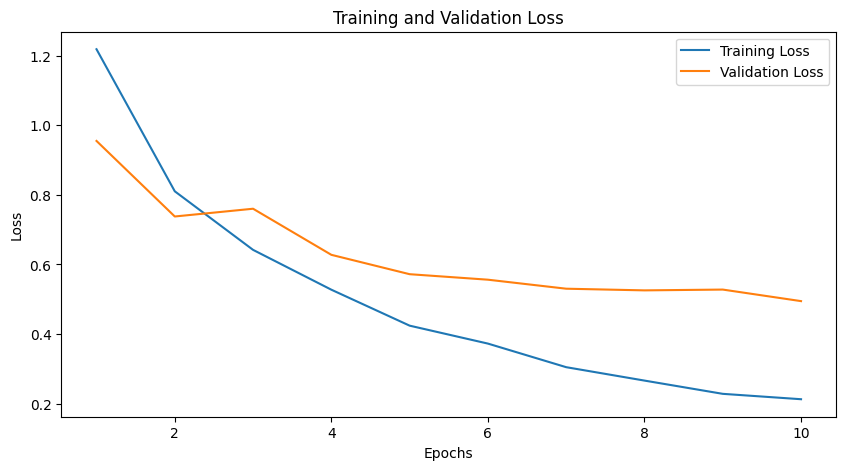

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Assume validation losses are stored in a list called val_losses
val_losses = [0.9549, 0.7377, 0.7600, 0.6275, 0.5718, 0.5560, 0.5301, 0.5253, 0.5276, 0.4944]

plt.figure(figsize=(10, 5))
plt.plot(epochs, average_epoch_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [26]:
val_losses = [0.9549, 0.7377, 0.7600, 0.6275, 0.5718, 0.5560, 0.5301, 0.5253, 0.5276, 0.4944]
val_accuracies = [68.77, 73.71, 73.00, 76.05, 82.84, 80.77, 84.03, 84.79, 84.52, 86.20]
epochs = range(1, 11)  # Assuming 10 epochs

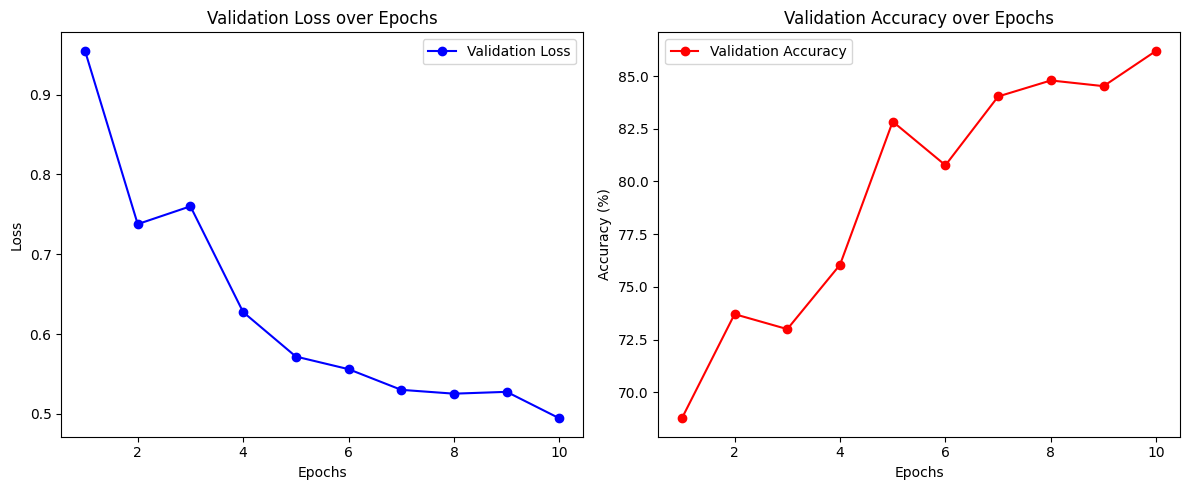

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'bo-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
# Create a new instance of the model class
siamese_net = SiameseNetwork(num_classes=6)

# Load the saved state_dict into the model
siamese_net.load_state_dict(torch.load('siamese_net1.pth'))
siamese_net.to(device)  # Move the model to the device (GPU or CPU)
siamese_net.eval()  # Set the model to evaluation mode

c:\Users\gaura\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gaura\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'torch' is not defined

In [11]:
train_dataset = TripletKinshipDataset(csv_file='train_triplet_dataset1.csv')
val_dataset = TripletKinshipDataset(csv_file='vvalidationtriplet.csv')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions and true labels
all_preds = []
all_labels = []

siamese_net.eval()
with torch.no_grad():
    for data in val_loader:
        anchor_img, positive_img, negative_img, label = data
        anchor_img, positive_img, negative_img, label = anchor_img.to(device), positive_img.to(device), negative_img.to(device), label.to(device)

        relationship_output = siamese_net.classify(anchor_img, positive_img)
        _, predicted = torch.max(relationship_output, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())



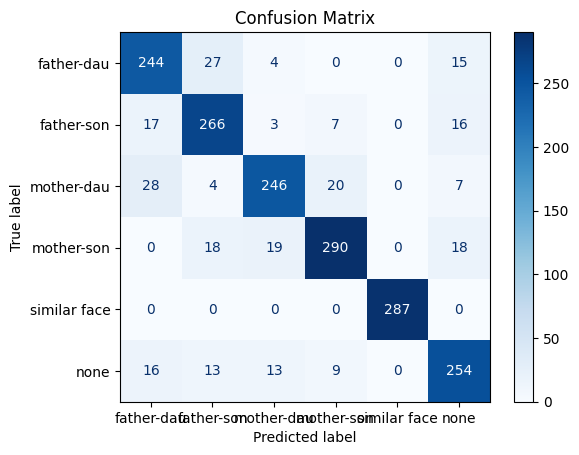

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the validation dataset
dataset = TripletKinshipDataset(csv_file='val_triplet_dataset1.csv')

# Continue with the rest of the steps to generate and plot the confusion matrix
label_mapping = dataset.label_mapping

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

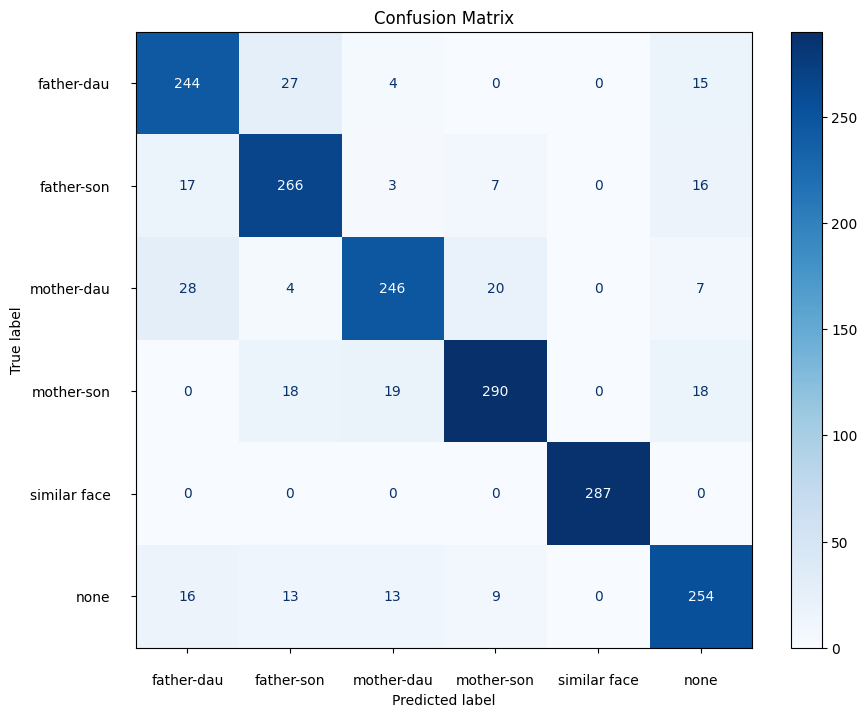

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the validation dataset
dataset = TripletKinshipDataset(csv_file='val_triplet_dataset1.csv')

# Continue with the rest of the steps to generate and plot the confusion matrix
label_mapping = dataset.label_mapping

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
fig, ax = plt.subplots(figsize=(10, 8))  # You can adjust the figure size for more space
cm_display.plot(cmap=plt.cm.Blues, ax=ax)

# Increase the gap between labels and the plot
ax.set_xticks(ax.get_xticks(), minor=False)
ax.set_yticks(ax.get_yticks(), minor=False)
ax.tick_params(axis='x', labelsize=10, pad=15)  # Increase the `pad` value for more space
ax.tick_params(axis='y', labelsize=10, pad=15)  # Increase the `pad` value for more space

plt.title('Confusion Matrix')
plt.show()


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming `all_labels` contains the true labels and `all_preds` contains the predicted labels

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score for each class
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1}")

# Classification Report (includes precision, recall, F1-score, support)
class_report = classification_report(all_labels, all_preds, target_names=list(label_mapping.keys()), zero_division=0)
print("\nClassification Report:\n", class_report)

# If you want a more comprehensive overview:
overall_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
overall_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
overall_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")


Accuracy: 0.8620
Precision per class: [0.8        0.81097561 0.86315789 0.88957055 1.         0.81935484]
Recall per class: [0.84137931 0.86084142 0.80655738 0.84057971 1.         0.83278689]
F1-score per class: [0.82016807 0.83516484 0.83389831 0.86438152 1.         0.82601626]

Classification Report:
               precision    recall  f1-score   support

  father-dau       0.80      0.84      0.82       290
  father-son       0.81      0.86      0.84       309
  mother-dau       0.86      0.81      0.83       305
  mother-son       0.89      0.84      0.86       345
similar face       1.00      1.00      1.00       287
        none       0.82      0.83      0.83       305

    accuracy                           0.86      1841
   macro avg       0.86      0.86      0.86      1841
weighted avg       0.86      0.86      0.86      1841

Overall Precision: 0.8638
Overall Recall: 0.8637
Overall F1-Score: 0.8633


In [10]:
# Create a new instance of the model class
import torch
siamese_net = SiameseNetwork(num_classes=6)

# Load the saved state_dict into the model
siamese_net.load_state_dict(torch.load('siamese_net1.pth'))
siamese_net.to(device)  # Move the model to the device (GPU or CPU)
siamese_net.eval()  # Set the model to evaluation mode

SiameseNetwork(
  (embedding_model): ResNetFeatureExtractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu)

In [11]:
def classify_images(img1_path, img2_path, model, transform, label_mapping):
    img1 = transform(Image.open(img1_path).convert('RGB'))
    img2 = transform(Image.open(img2_path).convert('RGB'))
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model.classify(img1, img2)
        _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()
    label = [k for k, v in label_mapping.items() if v == predicted_label][0]
    return label

In [12]:
# Classify two images
img1_path = r"C:\Users\gaura\OneDrive\Desktop\Thesis\families in the wild dataset\recognizing-faces-in-the-wild\train-faces\F0002\MID1\P00009_face3.jpg"
img2_path = r"C:\Users\gaura\OneDrive\Desktop\Thesis\families in the wild dataset\recognizing-faces-in-the-wild\train-faces\F0002\MID3\P00009_face1.jpg"
predicted_label = classify_images(img1_path, img2_path, siamese_net, dataset.transform, dataset.label_mapping)
print(f"The predicted relationship between the images is: {predicted_label}")

The predicted relationship between the images is: father-dau


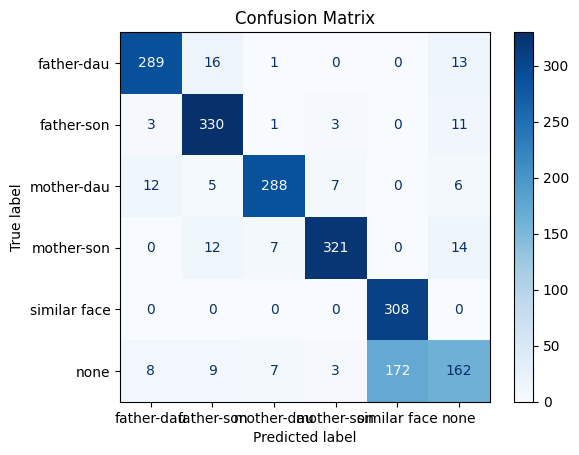

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the validation dataset
dataset = TripletKinshipDataset(csv_file='vvalidationtriplet.csv')

# Continue with the rest of the steps to generate and plot the confusion matrix
label_mapping = dataset.label_mapping

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming `all_labels` contains the true labels and `all_preds` contains the predicted labels

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score for each class
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1}")

# Classification Report (includes precision, recall, F1-score, support)
class_report = classification_report(all_labels, all_preds, target_names=list(label_mapping.keys()), zero_division=0)
print("\nClassification Report:\n", class_report)

# If you want a more comprehensive overview:
overall_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
overall_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
overall_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")


Accuracy: 0.8456
Precision per class: [0.92628205 0.88709677 0.94736842 0.96107784 0.64166667 0.78640777]
Recall per class: [0.90595611 0.94827586 0.90566038 0.90677966 1.         0.44875346]
F1-score per class: [0.91600634 0.91666667 0.92604502 0.93313953 0.78172589 0.57142857]

Classification Report:
               precision    recall  f1-score   support

  father-dau       0.93      0.91      0.92       319
  father-son       0.89      0.95      0.92       348
  mother-dau       0.95      0.91      0.93       318
  mother-son       0.96      0.91      0.93       354
similar face       0.64      1.00      0.78       308
        none       0.79      0.45      0.57       361

    accuracy                           0.85      2008
   macro avg       0.86      0.85      0.84      2008
weighted avg       0.86      0.85      0.84      2008

Overall Precision: 0.8583
Overall Recall: 0.8526
Overall F1-Score: 0.8408
